In [1]:
from rdkit import Chem

from My_Pka_Model_Output_Atom_Features import Pka_basic,Pka_acidic
import torch

import dgl
import dgllife
from torch.utils.data import DataLoader
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
import torch.optim as optim
import numpy as np
import random 
import pandas as pd

from torch.nn.utils import clip_grad_norm

Using backend: pytorch


In [2]:
seed = 0
random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')

def load_data(file_name,batch_size = 128,shuffle = True,split_ratio = False):
    dataset = []
    with open(file_name) as f:
        for line in f.readlines():
            line = line.replace('\n','').split('\t')
            g = smiles_to_bigraph(smiles=line[0], 
                          node_featurizer=node_featurizer,
                          edge_featurizer=edge_featurizer,
                          canonical_atom_order= False)
            dataset.append((g,float(line[1])))
            
    if split_ratio == False:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
        return dataloader
    else:
        random.shuffle(dataset)
        length = len(dataset)
        dataloader_list = []
        for i in split_ratio:
            num = round(length * i)
            dataset_part = dataset[:num]
            dataset = dataset[num:]
            dataloader = DataLoader(dataset_part, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
            dataloader_list.append(dataloader)
        dataset_part = dataset
        dataloader = DataLoader(dataset_part, batch_size=batch_size, shuffle=shuffle,collate_fn=collate)
        dataloader_list.append(dataloader)
        return dataloader_list

In [4]:
batch_size = 1024
epoch_num = 1000
layer_num = 6
learning_rate = 0.0003
weight_decay = 0.0003

In [6]:
model = Pka_acidic(node_feat_size = 74,
                   edge_feat_size = 12,
                   output_size = 1,
                   num_layers= layer_num,
                   graph_feat_size=200,
                   dropout=0.2)

model.load_state_dict(torch.load('./Trained_model/site_acidic_new_2.pkl',map_location='cuda:3'))
model = model.to('cpu')

In [7]:
smiles_lis = []
with open('./Dataset/all_acidic_smiles.txt') as f:
    for line in f.readlines():
        line = line.replace('\n','').split('\t')
        smiles_lis.append(line[0])
        print(line)

['CC(=O)OO', '8.2']
['O=C(c1ccc(-c2nn[nH]n2)cc1)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1', '3.6']
['CCCC(=O)OO', '8.2']
['O=COO', '7.1']
['O=C(NS(=O)(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1)c1ccccc1', '4.3']
['CCC(=O)OO', '8.2']
['N#Cc1c(O)nc(N)nc1-c1ccccc1', '6.52']
['Cn1ccc(O)nc1=O', '9.71']
['Oc1ncnc2ccccc12', '9.87']
['Cn1cc(Br)c(O)nc1=O', '7.84']
['CN(C)c1cc(O)ncn1', '10.49']
['Cc1cc(O)nc(C)n1', '9.82']
['Oc1cc2ccccc2nn1', '8.63']
['CSc1ncnc(O)c1C', '9.12']
['Oc1cncc2cccnc12', '8.35']
['CSc1cc(O)ncn1', '8.52']
['Cc1cc(O)ncn1', '9.1']
['Oc1cc2ccccc2cn1', '9.62']
['Cc1cncnc1O', '9.17']
['COc1cc(O)ncn1', '8.47']
['COc1cncnc1O', '8.64']
['Oc1ccncn1', '8.63']
['COc1nc(C)cc(O)n1', '8.5']
['OC(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F', '10.52']
['Oc1nccc2cccnc12', '12.04']
['Oc1nncc2ccccc12', '11.99']
['O[C@@H](C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F', '10.48']
['Oc1ccc2ccccc2n1', '11.76']
['Oc1ccccn1', '11.62']
['Oc1cccnn1', '10.5']
['O=Cc1ncccc1O', '6.95']
['O=C(Nc1ccc(N2CCOCC2)c(F)c

['COc1ccc(Cl)cc1S(=O)(=O)NC(=O)NC(C)C', '5.65']
['CC(=O)N1C[C@@]2(C(C)C)OC(=O)C[C@H]2[C@@H]1C(=O)O', '3.2']
['COc1cccc(OC)c1-c1ccc(C[C@H](NC(=O)c2c(Cl)cccc2Cl)C(=O)O)cc1', '3.41']
['N#Cc1ccc(O[C@H]2O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]2O)cc1', '3.22']
['O=C(O)CCc1ccc(Br)cc1', '4.33']
['FC(F)(F)c1ncnc2nc[nH]c12', '7.35']
['COc1cc(OC)c(/C=C/S(=O)(=O)Cc2ccc(OC)c(NS(C)(=O)=O)n2)c(OC)c1', '7.28']
['Cc1ccc(C(=O)O)c(C)c1', '4.18']
['C#CCCCCC(=O)O', '4.58']
['O=S(=O)(Nc1ccccn1)c1ccccc1', '8.2']
['CC(C(N)=O)S(N)(=O)=O', '9.86']
['Cc1cccc(O)c1C(=O)Oc1ccccc1', '8.63']
['CCc1cccc2ccc(O)cc12', '9.54']
['O=C(O)c1ccc(OCc2ccccc2)cc1', '4.44']
['O=c1[nH]c(=O)n([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)cc1I', '8.0']
['CCCc1cc(Cl)cc(Cl)c1O', '8.1']
['On1nnc2cc(Cl)ccc21', '4.18']
['NS(=O)(=O)c1ccc(SCCCCO)cc1', '10.17']
['CC(O)c1cccc(O)c1CO', '9.9']
['CC(C)(C(=O)O)c1nnnn1C1CCCCC1', '3.7']
['CC(C)C(Br)C(=O)O', '2.82']
['CCC(=O)c1nc(C(=O)O)cs1', '3.7']
['O=C(O)[C@]1(Cl)[C@H]2CCC[C@H]21', '3.03']
['Cn1cc(C(=O)O)c(=

['O=C(O)c1ccccc1C(F)(F)F', '2.7300000189999998']
['O=C(O)c1ccc([N+](=O)[O-])cc1O', '2.230000019']
['O=C(O)CCc1ccccc1O', '4.75']
['Cc1ccc(P(=O)(O)O)cc1', '1.980000019']
['COc1ccccc1OCC(=O)O', '3.2300000189999998']
['CCC(CC(=O)O)CC(=O)O', '4.289999962']
['Cc1ccc(S(=O)(=O)CC(=O)O)cc1', '2.539999962']
['CC(C)CC(N)C(=O)NC(CC(C)C)C(=O)O', '3.450000048']
['O=[Se](=O)(O)c1ccccc1-c1ccccc1', '4.670000076']
['CCC(Cl)C(=O)O', '2.859999895']
['COc1ccccc1C(O)C(=O)O', '3.640000105']
['O=C(O)COc1ccc(Br)cc1', '3.1300001139999996']
['O=C(O)CCSCCC(=O)O', '4.110000134']
['ON=Cc1ccccc1O', '9.199999809']
['Oc1cc(Cl)c2ccccc2c1', '8.819999695']
['Cc1ccc(O)c2ccccc12', '9.640000342999999']
['CC=C(C)C(=O)O', '4.3000001910000005']
['Cc1ccc([Se](=O)(=O)O)cc1', '4.8800001139999996']
['O=C(O)C(O)C(O)C(=O)O', '2.8800001139999996']
['NCCCCCP(=O)(O)O', '2.599999905']
['O=C(O)CSc1ccc(F)cc1', '3.5799999239999996']
['CCOc1ccc(P(=O)(O)O)cc1', '2.0599999430000002']
['O=C(O)CSC(F)(F)F', '2.950000048']
['NCCCCP(=O)(O)O', '2.5

['O=NN(O)c1cc(Cl)ccc1Cl', '3.529999971']
['O=NN(O)c1ccc(Cl)c(Cl)c1', '3.849999905']
['O=NN(O)c1ccc(-c2ccccc2)cc1', '3.970000029']
['O=NN(O)c1cccc(Cl)c1', '4.0199999810000016']
['O=NN(O)c1ccccc1Cl', '3.779999971']
['O=C(c1ccc(Br)cc1)N(O)c1cccc(Cl)c1', '9.300000191']
['O=C1CCC(=O)N(O)CCCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCN1', '8.640000342999999']
['O=C1CCC(=O)NCCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCCN1', '8.789999962000001']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCNC(=O)CCC(=O)N(O)CCCCCN1', '8.600000381000001']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCNC(=O)CCC(=O)N(O)CCCCN1', '8.579999924']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCOCCNC(=O)CCC(=O)N(O)CCCCCN1', '8.609999657000001']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCOCCNC(=O)CCC(=O)N(O)CCOCCN1', '8.590000153']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCSCCNC(=O)CCC(=O)N(O)CCCCCN1', '8.569999695']
['O=C1CCC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCSCCNC(=O)CCC(=O)N(O)CCSCCN1', '8.529999733']
['O=C1CCC(=O)N(O)CCCCNC(=O

In [8]:
atom_feature_lis = []

In [9]:
counter = 0
for smiles in smiles_lis:
    bg = smiles_to_bigraph(smiles= smiles, 
              node_featurizer=node_featurizer,
              edge_featurizer=edge_featurizer,
              canonical_atom_order= False)

    with torch.no_grad():
        model.eval()
        g_feats,atom_pka,node_feats = model(bg,bg.ndata['h'], bg.edata['h'])
        atom_feature_lis.append(node_feats)
        
    print(smiles)

CC(=O)OO
O=C(c1ccc(-c2nn[nH]n2)cc1)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
CCCC(=O)OO
O=COO
O=C(NS(=O)(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1)c1ccccc1
CCC(=O)OO
N#Cc1c(O)nc(N)nc1-c1ccccc1
Cn1ccc(O)nc1=O
Oc1ncnc2ccccc12
Cn1cc(Br)c(O)nc1=O
CN(C)c1cc(O)ncn1
Cc1cc(O)nc(C)n1
Oc1cc2ccccc2nn1
CSc1ncnc(O)c1C
Oc1cncc2cccnc12
CSc1cc(O)ncn1
Cc1cc(O)ncn1
Oc1cc2ccccc2cn1
Cc1cncnc1O
COc1cc(O)ncn1
COc1cncnc1O
Oc1ccncn1
COc1nc(C)cc(O)n1
OC(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F
Oc1nccc2cccnc12
Oc1nncc2ccccc12
O[C@@H](C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)F
Oc1ccc2ccccc2n1
Oc1ccccn1
Oc1cccnn1
O=Cc1ncccc1O
O=C(Nc1ccc(N2CCOCC2)c(F)c1)c1nnc(Nc2ccccc2F)o1
Oc1cncc2ccccc12
O=Cc1ccncc1O
CN(C)c1ccccc1S(=O)(=O)NC(=O)N1CCC(N2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)CC1
CCOc1ccnc(O)n1
Oc1ncc2ccccc2n1
Oc1ccnc2ccccc12
OC(C(F)(F)F)C(F)(F)F
Oc1ccnc2cccnc12
CN(C)c1ccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl)c(Cl)c4)CC3)CC2)cc1
Nc1ccccc1S
Oc1cccnc1
CCCc1c(C)nc(O)nc1C
Cc1nc(O)nc(C)c1C
Cc1nc2ccccc2nc1O
Cc1cc(C)nc(O)n1
Nc1cnccc1O
C=C

Oc1ccc2ccccc2c1/N=N/c1nccs1
COc1ccccc1-c1ccccc1O
CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1
O=C(O)c1c(O)cccc1O
O=C1c2ccccc2C(=O)c2cc(S(=O)(=O)O)ccc21
CC(C)(O)C(F)(F)F
COc1ccc2c(c1)C(=O)N(CCc1ccc(S(=O)(=O)NC(=O)NC3CCCCC3)cc1)C(=O)C2(C)C
CC(=O)NCCS
O=[N+]([O-])c1cc(Br)c(O)c(Br)c1
CC(C)[P@@H](=O)O
CCC[P@@H](=O)O
O=C(O)C(c1ccccc1)(c1ccccc1)c1ccccc1
CC[C@@](CC(=O)OC)(Cc1ccc([N+](=O)[O-])cc1)C(=O)O
COc1ccc(NS(=O)(=O)c2ccccc2)cc1
CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3nnnn3C)CS[C@@H]21
CC(=O)C[C@H](c1ccccc1)c1c(O)c2ccccc2oc1=O
Cc1ccccc1/N=N/c1ccc(O)c(C(=O)O)c1
O=[N+]([O-])c1cccc(S)c1
COC(=O)c1cccc(C)c1S(=O)(=O)NC(=O)Nc1nc(OCC(F)(F)F)nc(N(C)C)n1
O=C(O)CCCC[C@@H]1CCSS1
CC(C)c1ccccc1C(=O)O
CC(C)(S)CO
O=C(O)c1c(Cl)cccc1CO
CCOc1nc(NC)nc(NC(=O)NS(=O)(=O)c2ccccc2C(=O)OC)n1
O=C(O)C(CO)(CO)CO
Oc1ccccc1Cc1ccccc1O
CCCC[P@@H](=O)O
CCCCCC(=O)NO
O=C(O)COCCN1CCN([C@H](c2ccccc2)c2ccc(Cl)cc2)CC1
O=C(c1ccccc1)N(O)c1ccccc1
O=CNO
CCOC(=O)N1CCC(c2cc(=O)n(-c3ccccc3)[nH]2)CC1
CCCNC(=O)NS(=O)(=O)c1ccc(Cl)cc1
O=

Cc1ccc(C)c(O)c1
O=C(O)c1ccc(C2CCCC2)cc1
C[C@@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
O=C(O)CC(=O)C(Cl)Cl
C[C@H](C(=O)O)c1cccc(C(=O)c2ccccc2)c1
O=C(O)C(Br)Br
O=C(O)c1cc([N+](=O)[O-])ccc1O
CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C\c1ccc([S@](C)=O)cc1
Cc1cc(Cl)ccc1O
Cc1cccc(O)c1
CCCOc1cccc(C(=O)O)c1
Cc1cc2ccccc2c(C(=O)O)c1C
Oc1cc(Cl)cc(Cl)c1
C[N+](C)(C)c1cccc(CC(=O)O)c1
COc1ccc2cc([C@H](C)C(=O)O)ccc2c1
COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2OCCCl)n1
Oc1cccc(F)c1
Cc1ccc(C(=O)c2ccccc2C(=O)O)cc1
COC(=O)c1cc(O)c2ccccc2c1
COc1ccc(C(=O)NO)cc1
CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O
O=C(O)Cc1c(Cl)ccc(Cl)c1Cl
C[C@H](Oc1ccc(Cl)cc1Cl)C(=O)O
Cc1cc(Br)ccc1C(=O)O
COc1ccc([P@@H](=O)O)cc1
Cc1cc(Cl)ccc1OCC(=O)O
CCCc1nc(C(C)(C)O)c(C(=O)OCc2oc(=O)oc2C)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
C=CC[C@@H](C)C(=O)O
Cc1ccc([N+](=O)[O-])c(O)c1
COC(=O)C[C@@H](C(=O)O)c1ccccc1
CCOCC(=O)O
CCc1cccc2c3c([nH]c12)[C@](CC)(CC(=O)O)OCC3
O=C(O)/C=C/c1ccccc1Br
CCc1cc2c(O)ccc(CC)c2s1
CC(C)c1cccc(O)c1
O=C(O)Cc1ccc(

CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C
N=C(N)NS(=O)(=O)c1ccc(N)cc1
Cc1ncc(CO)c(CO)c1O
CC(CCc1ccccc1)NCC(O)c1ccc(O)c(C(N)=O)c1
C[C@@H]1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)C[C@]2(O)CC(O)C(C(=O)O)C(CC(O[C@H]3O[C@H](C)[C@@H](O)[C@H](N)[C@@H]3O)/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2
O=S(Cc1ccccn1)c1nc2ccccc2[nH]1
O=C(CCCCC(=O)Nc1c(I)cc(I)c(C(=O)O)c1I)Nc1c(I)cc(I)c(C(=O)O)c1I
C[C@H]1[C@H](NC(=O)/C(=N\OC(C)(C)C(=O)O)c2csc(N)n2)C(=O)N1S(=O)(=O)O
Nc1nc(=S)c2[nH]cnc2[nH]1
CC(C)NCC(O)c1cc(O)cc(O)c1
Nc1ccc(S(=O)(=O)Nc2nccs2)cc1
Cn1c(=O)c2[nH]c(Cl)nc2n(C)c1=O
S=c1nc[nH]c2nc[nH]c12
CC(=O)Nc1c(I)c(NC(C)=O)c(I)c(C(=O)O)c1I
CCOC(=O)C(c1c(O)c2ccccc2oc1=O)c1c(O)c2ccccc2oc1=O
NC(=O)c1ccccc1O
COc1ccc(-c2nc(C(F)(F)F)[nH]c2-c2ccc(OC)cc2)cc1
CC1(C)[C@@H](OC(=O)CCC(=O)O)CC[C@@]2(C)[C@H]1CC[C@]1(C)[C@@H]2C(=O)C=C2[C@@H]3C[C@@](C)(C(=O)O)CC[C@]3(C)CC[C@]21C
O=C1OC(c2ccc(O)cc2)(c2ccc(

Oc1ccc2c3c1O[C@H]1[C@@H](O)CC[C@@]4(O)[C@@H](C2)N(CC2CCC2)CC[C@]314
CC1(C)S[C@@H]2[C@H](NC(=O)C(C(=O)O)c3ccccc3)C(=O)N2[C@H]1C(=O)O
CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)[C@H]3[C@H](O)[C@@H]12
Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](O)c3ccccc3)[C@H]2SC1
CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)N3CCN(S(C)(=O)=O)C3=O)c3ccccc3)C(=O)N2[C@H]1C(=O)O
Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12
CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12
CC(=O)Nc1nnc(S(N)(=O)=O)s1
C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@@H]21
CC(=O)Nc1ccc(C(=O)Nn2cnnc2)cc1
Nc1nonc1/C(=N/O)Nc1ccccc1
O=C(NC1=CON=CC=C1)c1cccc(O)c1
COCCNCCn1cnc2c1c(=O)[nH]c(=O)n2C
Nc1ccc(O)c(-c2nc3cc(Cl)ccc3o2)c1
CCOC(=O)c1sc(NC(=S)NC(=O)c2ccccc2)nc1C
O=[N+]([O-])c1ccccc1S(=O)(=O)Nc1ccc(Cl)cc1
ON=Cc1c(O)c(Br)cc2oc3c(c12)CCCC3
COc1cccc(C2Nc3ccccc3C(=O)N2O)c1
NS(=O)(=O)c1ncccc1I
CCS(=O)(=O)c1ncccc1S(N)(=O)=O
COc1c

SC1CC1c1ccccc1
Nc1cccc(S)c1
Nc1ccc(S)cc1
CN(C)c1ccccc1S
CN(C)c1cccc(S)c1
CN(C)c1ccc(S)cc1
COc1ccccc1S
Oc1ccccc1S
Oc1cccc(S)c1
Oc1ccc(S)cc1
CC(C)(C)c1ccccc1S
CC(C)(C)c1cccc(S)c1
CC(C)(C)c1ccc(S)cc1
O=Cc1ccccc1S
O=Cc1cccc(S)c1
O=Cc1ccc(S)cc1
COC(=O)c1ccccc1S
COC(=O)c1cccc(S)c1
COC(=O)c1ccc(S)cc1
O=[N+]([O-])c1ccccc1S
N#Cc1ccccc1S
N#Cc1cccc(S)c1
N#Cc1ccc(S)cc1
Sc1ccco1
Sc1ccoc1
Sc1cccs1
Sc1ccsc1
Sc1ccc[nH]1
Sc1cc[nH]c1
Sc1ccno1
Sc1cnoc1
Sc1ccon1
O=Cc1ccoc1S
O=Cc1coc(S)c1
O=Cc1ccc(S)o1
N#Cc1ccoc1S
N#Cc1coc(S)c1
N#Cc1ccc(S)o1
O=[N+]([O-])c1ccoc1S
O=[N+]([O-])c1coc(S)c1
O=[N+]([O-])c1ccc(S)o1
Nc1ccoc1S
Nc1coc(S)c1
Nc1ccc(S)o1
Oc1ccoc1S
Oc1coc(S)c1
Oc1ccc(S)o1
COc1ccoc1S
COc1coc(S)c1
COc1ccc(S)o1
Sc1occc1-c1ccccc1
Sc1cc(-c2ccccc2)co1
Sc1ccc(-c2ccccc2)o1
O=Cc1occc1S
O=Cc1cocc1S
O=Cc1cc(S)co1
N#Cc1occc1S
N#Cc1cocc1S
N#Cc1cc(S)co1
O=[N+]([O-])c1occc1S
O=[N+]([O-])c1cocc1S
O=[N+]([O-])c1cc(S)co1
Nc1occc1S
Nc1cocc1S
Nc1cc(S)co1
Oc1occc1S
Oc1cocc1S
Oc1cc(S)co1
COc1occc1S
COc1cocc1S
COc1cc(S)co1
Sc1

CCOC(=O)C(Cc1ccc(C)cc1)=C(C)O
CCOC(=O)C(Cc1cccc(C)c1)=C(C)O
CCOC(=O)C(Cc1ccccc1)=C(C)O
CCOP(=O)(OCC)c1ccc(-c2cc(=O)o[nH]2)o1
O=S(=O)(Cc1ccccc1)c1ncn[nH]1
CC(=O)C1=C(O)CCCC1
O=c1cc(O)n2ncc(-c3ccccc3)c2[nH]1
COc1ccccc1Oc1c(NS(=O)(=O)c2ccc(C(C)(C)C)cc2)nc(-c2ncccn2)nc1OCCO
O=c1cc(O)n2ncc(-c3ccc(Br)cc3)c2[nH]1
CC(=O)C1=C(O)c2ccccc2C1=O
O=c1cc(O)n2nccc2[nH]1
O=c1c(O)c1-c1ccccc1
Cn1cnc2[nH]c(=O)[nH]c(=S)c21
O=c1c(O)c1-c1ccc(F)cc1
S=c1nc(CCc2ccccc2)[nH]o1
Cn1nc(Cl)nc1NN=O
Cn1ncnc1NN=O
CC(C)(C)c1ccc(-c2c(O)c2=O)cc1
Cc1nc(-c2ccccc2)oc1O
Cc1[nH]nc2c1c(=O)n(C)c(=O)n2C
COc1ccc(-c2c(O)c2=O)cc1
Cn1c(=O)n(NS(C)(=O)=O)c(=O)c2ccc(Cl)cc21
CC1(C)O[C@@H]2CO[C@@]3(CNS(N)(=O)=O)OC(C)(C)O[C@H]3[C@@H]2O1
N#CNS(=O)(=O)c1ccc(N)cc1
O=c1cc(-c2ccccc2)[nH][nH]1
Cc1[nH]n(-c2ccccc2)c(=O)c1C
S=CNc1ccccc1Cl
CC(=O)c1cc(C)c(C)cc1O
Oc1oc(-c2ccccc2)nc1Cc1ccccc1
CC(=O)C(C)=C(O)C(C)C
CONC(=O)CCc1ccccc1
S=C1NC(=S)C(c2ccccc2)N1
COc1ccc(Cn2cc(-c3nn[nH]n3)c(=O)c3c(F)ccc(F)c32)cc1
S=c1[nH]c(=S)c2[nH]cnc2[nH]1
Cc1[nH][nH]c(=O)c1-c

CCCCCCCc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
CC(C)N=C1Nc2c(Cl)cccc2S(=O)(=O)N1
O=C1NC(c2ccccc2)CC(O)=C1Sc1ccccc1Cl
COc1ccc(/C=C2/SC(=S)NC2=O)cc1
N#Cc1csc(NC(=O)Nc2ccc(Cl)c(Cl)c2)n1
CC(=O)NCc1cc(C)cc(CNC(C)=O)c1O
CN1C(=O)C(C)(C)NC1=S
CC(C)(C)c1ccc(S(=O)(=O)Nc2ccc(Cl)cc2C(=O)c2cc[n+]([O-])cc2)cc1
O=C1NC(=O)c2ccccc21
CS(=O)(=O)Nn1c(=O)[nH]c2cc(C(F)(F)F)ccc2c1=O
CC(C)(C(N)=O)S(=O)(=O)NC(N)=O
CN(n1c(=O)[nH]c2cc(Cl)ccc2c1=O)S(C)(=O)=O
COc1ccccc1-c1cn[nH]n1
Cc1ccc(=O)c(O)c(Br)c1
CCc1oc2ccccc2c1C(=O)Cc1cc(Br)c(O)c(Br)c1
O=c1cc(-c2ccc(O)cc2)ss1
CC(=O)C(=C(C)O)c1ccccc1
O=c1cc(-c2ccc(O)cc2)oc2ccccc12
CCCC12CCC(=O)C=C1c1c(cc(SCC(=O)O)c(Cl)c1Cl)C2
O=C(O)CN1C(=O)c2cccc3cccc(c23)C1=O
O=c1[nH]c(-c2ccc(C(F)(F)F)cc2)nc2c1CCOC2
C[n+]1ccc2cc(O)ccc2c1
S=C1NCCO1
CCCC(=O)c1cc(C(C)=O)n[nH]1
C[n+]1cccc2c(O)cccc21
CC(C)NC(=S)S
CCS(=O)(=O)c1ccc(CC(=O)Nc2nc(-c3ccccc3)c(C(=O)c3ccccc3)s2)cc1
CCN(CC)C(=O)NO
CC/C(C)=C\C(=O)O
Cc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
NC(=O)CS(=O)(=O)NC(N)=O
COc1ccc(-c2nc3ncncc3[nH]2)c(OC)c1
O=

O=S(=O)(Nc1cncc(Br)c1)c1ccccc1C(F)(F)F
OC[C@H]1O[C@H](Oc2ccc(-c3cc(F)c(O)c(F)c3)cc2)[C@@H](O)[C@@H](O)[C@@H]1O
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cc(F)ccc2n1CC(=O)O
Cc1ccnc(NS(=O)(=O)c2ccc(Cl)cc2)n1
O=C(CCc1ccccc1)NO
Cc1cn(C2CC(N=[N+]=[N-])C(COP(=O)(NC(C)C)OCCSC(=O)C(C)(C)C)O2)c(=O)[nH]c1=O
O=C(c1ccccc1)c1ccn[nH]1
O=C(O)C12CC3(F)CC(F)(CC(F)(C3)C1)C2
O=C(O)c1ccnnc1
Cc1[nH]c2ccccc2c1C(=O)O
O=C(O)COc1cc2c(c(Cl)c1Cl)C(=O)C(CC1CCCC1)C2
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cc(S(C)(=O)=O)ccc2n1CC(=O)O
O=C(O)[C@H]1C[C@H]2CC[C@@H]1C2
O=C1C=C(O)C(Cc2ccccc2)C1
CC1(Cc2ccccc2)Cc2cc(OCC(=O)O)c(Cl)c(Cl)c2C1=O
Cn1cnc2[nH]c(=O)[nH]c(=O)c21
O=C(NO)Nc1ccccc1
N#Cc1ccc(S(=O)(=O)Nc2ccc3cc[nH]c(=O)c3c2)cc1
O=c1ccc2cc(O)c(O)cc2o1
Clc1cccc(-c2cn[nH]n2)c1
O=C(O)Cc1ccco1
Cc1c(-c2ccccc2)c(=O)oc2cc(O)ccc12
Cc1c(-c2ccc(=O)n(Cc3ccccc3)n2)c2cccc(Br)c2n1CC(=O)O
O=c1cc(O)c2ccccc2o1
CCCCCc1c(-c2ccccc2)[nH]n(-c2ccccc2)c1=O
O=c1ccc(S(=O)(=O)c2ccccc2)n[nH]1
CC(=O)C=C(O)CC(C)C
Cc1cc(=O)oc2cc(O)ccc12
COc1c(C(=O)O)oc2ccccc12
C/C(=C\c

O=C(O)C1CC1(Br)Br
N#Cc1c(-c2ccc(Cl)cc2)nc(SCC(=O)Nc2ccc(Cl)cc2)[nH]c1=O
COc1ccc([C@H]2C[C@@H]2C(=O)O)cc1
Nc1ccccc1C(=O)O
O=C(O)C12CC3CC(CC(F)(C3)C1)C2
C[C@H]1CC[C@H](C)C1C(=O)O
N#Cc1ccc(NS(=O)(=O)c2ccccc2C(F)(F)F)cc1Cl
O=C1CCCC(=O)N1O
O=C1CC(c2ccccc2)NC(=O)N1
O=C(Cc1cccc2ccccc12)N[C@H](Cc1cc2ccc(F)cc2[nH]1)C(=O)O
N#Cc1ccc(-c2nn[nH]n2)cc1
CCO[C@H]1C[C@H]1C(=O)O
COc1ccccc1/C=C\C(=O)O
O=C(O)c1nsc2ccccc12
NS(=O)(=O)c1cccc(C(F)(F)F)c1
N#Cc1cccc(S(N)(=O)=O)c1
COc1c(O)ccc2c1C[N+]1(C)CCc3cc4c(cc3[C@@H]1C2)OCO4
CCC(=O)c1cc(C(=O)C(C)(C)C)n[nH]1
Oc1cccc2cc3ccccc3cc12
O=C(O)c1ccccc1Cl
CCC1=C(O)C(CC)C1=O
C[C@](Cc1c[nH]c2ccccc12)(NC(=O)OC1C2CC3CC(C2)CC1C3)C(=O)NC[C@@H](NC(=O)CCC(=O)O)c1ccccc1
C[C@@](Cc1c[nH]c2ccccc12)(NC(=O)OC1C2CC3CC(C2)CC1C3)C(=O)NC[C@H](NC(=O)CCC(=O)O)c1ccccc1
O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2cc(F)ccc2[nH]1
CNC(=O)/C=C(/C)C(=O)O
O=C(Nc1ccc(F)cc1C(=O)O)c1cccc(S(=O)(=O)N2CCOCC2)c1
COc1ccc(Cl)c(Nc2ccccc2CC(=O)O)c1Cl
CCC12CCC(=O)C=C1c1c(cc(OCC(=O)O)c(Cl)c1Cl)C2
CCCC12CCC(=O)C=

Oc1ccc2c(c1)Cc1ccccc1-2
COc1ccc2cc3[n+](cc2c1O)CCc1cc2c(cc1-3)OCO2
CC([P])C(=O)O
COc1cccc2c1c(NS(=O)(=O)c1ccc(Cl)s1)nn2Cc1cccc(CNC(C)=O)c1
O=Nc1c(O)ccc2ccccc12
CC(=O)c1ccc(O)c2ncccc12
CC(=O)c1cccc(NS(=O)(=O)C(F)(F)F)c1
Nc1ccc(S(=O)(=O)Nc2nncs2)cc1
CS(=O)(=O)Nc1ccc(C(F)(F)F)cc1
N#Cc1ccc(S(=O)(=O)NCc2ccccc2)cc1
CC(=O)N(C)O
Cc1cccc(Cl)c1C(=O)O
CC1(C)CCc2c(cc(Cl)c(O)c2Cl)O1
Cc1c(O)c(=O)ccn1C
O=C(c1cccc(F)c1)c1ccc2n1CCC2C(=O)O
CCCCCOC(=O)c1ccc(OS(N)(=O)=O)cc1
CCOc1ccc(C(=O)c2ccc3n2CCC3C(=O)O)cc1
CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
C/C=C/C1=C(O)c2ccccc2C(=O)C1=O
Cc1cnc(-c2ccccc2)c(=O)[nH]1
CCOc1cccc(C(=O)c2ccc3n2CCC3C(=O)O)c1
CCc1cccc2c3c([nH]c12)C(CC)(CC(=O)O)OCC3
Cn1c(=S)[nH]c2cc3c(cc21)CCCC3
Cc1[nH]c2ccccc2c1CC(=O)O
Cc1ccc(NS(=O)(=O)Cc2ccccc2)c(=O)n1CC(=O)NCc1ccc2c(N)noc2c1
Cc1ccc(S(=O)(=O)NCCC(=N)N(C)C)cc1
On1nnc2c(Cl)cccc21
O=C(O)[C@@H]1O[C@H](Oc2ccc3[nH]ccc(=O)c3c2)[C@@H](O)[C@H](O)[C@H]1O
COc1ccc(/C=C\C(=O)O)cc1
CCC[n+]1cccc2cc(O)ccc21
CN1C(=S)NC(=O)C12CCCCC2
O=c1c(CCS(=O

Cc1ccc(C(O)C(C(=O)O)c2ccc(-c3ccccc3)cc2)cc1
CSc1ccccc1C(=O)O
O=C(O)c1ccc(-c2ccc(O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]3O)c(Cl)c2)cc1
COc1cc(C(F)(F)F)ccc1-c1cccc2cc(S(=O)(=O)Nc3ncns3)ccc12
COc1cccc(C)c1C(=O)O
C=C=CC(=O)O
O=C(O)Cc1nnnn1-c1ccccc1
CN1c2ccc(C#N)cc2N=C(c2ccc(C(=O)O)cc2)c2cc3c(cc21)C(C)(C)CCC3(C)C
O=C(O)c1cc(-c2ccccc2)oc(=O)c1
O=C(O)[C@@H]1C[C@@H]1c1ccccc1
CC(C)CCOc1ccccc1/C=C\C(=O)O
O=C(O)C1(O)CCC1
Clc1ncnc2nc[nH]c12
O=C(O)c1ccccc1CO
CCCCS(=O)O
CC(=O)OCCCS(=O)(=O)c1ccc(S(N)(=O)=O)s1
COc1ccc(Cl)cc1S(=O)(=O)NC(=O)Nc1ccccc1
CC(=O)[C@H]1CC=CC[C@@H]1C(=O)O
c1ccc(-c2ncn[nH]2)cc1
CC(C#N)(Cc1ccccc1)C(=O)O
Cc1cc(O)cc([N+](C)(C)C)c1
Cc1ccc(C)n1-c1ccc(C(=O)O)c(O)c1
Cc1c(I)cccc1C(=O)O
C[C@]12CC[C@@H]3C(=O)O[C@@H](C(=O)O)C[C@]3(C)[C@H]1[C@H]1CCC2(O)C(=O)O1
O=C(O)Cn1cccc1
O=S(=O)(Nc1ccccc1)c1ccc(F)cc1
CCOc1ccc(C(=O)O)cc1
CCN(CC)C(=S)S
CCCCc1cc(Cl)cc(Cl)c1O
O=C1NC(=O)C(Cc2ccccc2)N1
CC(O)CC(=O)O
CC(C)CCC1=C(O)c2ccccc2C(=O)C1=O
O=C(O)c1cccccc1=O
O=C(O)[C@@H]1O[C@H](Oc2ccc(I)cc2)[C@@H](O)[C

C[C@H](C1CC1C(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C
CC(C1CC1C(=O)O)C1CC[C@H]2[C@@H]3[C@@H](O)CC4C[C@H](O)CCC4(C)[C@H]3CCC12C
Cn1cnc2c(=O)[nH]cnc21
NS(=O)(=O)c1cc2c(s1)S(=O)(=O)CCC2O
Cc1ccc2nc(C(F)F)[nH]c(=O)c2c1
CCCCCOc1ccc(C(=O)O)cc1
Cc1ccc2ccc(O)cc2c1
CC(=O)OCCCCCc1ccc(S(N)(=O)=O)cc1
Cc1cc(C(=O)O)c(C)o1
Fc1cccc(CN(Cc2nn[nH]n2)c2ccccc2)c1
Cc1ccc(Br)c(C(=O)O)c1
CC(C)(C)c1ccc(C(=O)/C=C/C(=O)O)cc1
CC(C)(CO[N+](=O)[O-])C(=O)Oc1ccccc1C(=O)O
O=S(=O)(Cc1ccccc1)c1ccccc1O
CC/C=C/CC(=O)N[C@H]1C(=O)N2[C@H]1SC(C)(C)[C@H]2C(=O)O
C[N+]1(CCC(=O)O)CCCCC1
C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C
CCSC(C)C(=O)O
CC1CCn2nnnc2C(C(=O)O)C1
CCC1(C)NC(=O)c2cc(S(=O)(=O)Nc3ccc(Cl)cc3)ccc2NC1=O
Cc1ccc(C(=O)O)cc1Cl
Cc1ccc(Cl)cc1C(=O)O
Oc1ccc2cccc(-c3ccccc3)c2c1
COC(=O)c1cc(S(N)(=O)=O)ccc1S(=O)(=O)CCCO
CC(C)Cc1ccc(O)cc1
CCCC[As](=O)(O)CCCC
Oc1ccc2ccc(Cl)cc2c1
CCCCOc1ccc(C(=O)O)cc1
S=c1[nH]c2cc3c(cc2[nH]1)CCCC3
OC

O=C(O)c1ccco1
O=C(O)c1cccnn1
CC(C)c1cccc(C(=O)O)c1
CC(C)(Cl)C(=O)O
CN(C)C(=S)NCC(=O)O
O=C(O)C1CCCOC1
CCC#CC(=O)O
CC(C)Oc1ccccc1C(=O)O
O=C(O)CCCCC1CCSS1
O=C(O)CSCc1ccccc1
O=C(O)CSC(c1ccccc1)(c1ccccc1)c1ccccc1
NC(=O)c1ccccc1C(=O)O
Oc1ccccc1-c1cc2ccccc2cc1O
CC(Cl)C(=O)O
C[As](C)(=O)O
Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
CCCCC(CC)C(=O)O
COc1cccc(C(=O)O)c1C
Cc1cccc(C(=O)O)c1I
O=C(O)c1ccccc1-c1ccccc1
CC(C#N)C(C)(C)C(=O)O
Cc1ccc(O)c(CO)c1
CC(=O)Sc1ccc(O)cc1
NS(=O)(=O)c1ccc(SCCO)c(F)c1
O=C(O)c1cc(Br)cs1
C[C@H]1CC[C@H](C(=O)O)CC1
N#Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O
CCC(O)C(C(=O)O)c1ccc(-c2ccccc2)cc1
O=C(O)c1ccccc1Nc1ccc(CCc2ccc(Cl)c(Cl)c2)cc1
CC(C)c1csc(C(=O)O)c1
Cc1ccc2nc(C(F)(F)F)[nH]c(=O)c2c1
CCCCCCC(=O)O
CC(=O)[C@H]1C[C@@H](CC(=O)O)C1(C)C
Cc1cccc(C(=O)O)c1Br
O=C(O)c1ccc(CO)cc1
CCCCCCCC(=O)N[C@H]1C(=O)N2[C@H]1SC(C)(C)[C@H]2C(=O)O
Cc1cc(C(=O)O)n[nH]1
Cn1c(=O)c2c([nH]c(=O)n2C)n(C)c1=O
COc1c(CC=C(C)C)c(O)c(C(=O)O)c(CCc2ccccc2)c1CC=C(C)C
C=CC(Cl)C(=O)O
O=C(O)C(c1ccc(-c2ccccc2)cc

Nc1ncccc1O
Cc1cc(O)nn1-c1ccccc1
Cc1ncc(CO)c(C)c1O
NC(=O)C=C(O)c1cccnc1
O=[N+]([O-])c1[nH]cnc1Cl
CCCCCCc1c(-c2ccccc2)n[nH]c1O
CC(=Nc1ccccc1O)c1ccccc1O
Cc1nn(-c2ccccc2)c(O)c1Cc1ccccc1
CCCC1N=C(N)N=C(Nc2ccc(SC)cc2)N1
CC(C#[N+][O-])=NO
Nc1ccc(B(O)O)c([N+](=O)[O-])c1
Cc1cc(O)n(-c2ccccc2)n1
CCc1c(C)nn(-c2ccccc2)c1O
Cc1nn(-c2ccccc2)c(O)c1C1CCCCC1
Cn1cnc2c1c(O)nc(O)[n+]2C
CCCCCc1c(-c2ccccc2)n[nH]c1O
CC(=S)Nc1ccc([N+](=O)[O-])cc1
CCCCc1c(-c2ccccc2)n[nH]c1O
Cc1nn(-c2ccccc2)c(O)c1C(C)C
O=S(=O)(Cc1ccccc1)c1cnn[nH]1
O=[N+]([O-])c1ccc(NC=S)cc1
Cc1nn(-c2ccccc2)c(O)c1C
O=NNc1nc([N+](=O)[O-])nn1-c1ccccc1
Nc1nc(O)[n+](C2CC(O)C(CO)O2)cc1CO
Nc1ccc([N+](=O)[O-])c(B(O)O)c1
CNc1nc(O)[n+](C2CC(O)C(CO)O2)cc1C
CCCc1c(-c2ccccc2)n[nH]c1O
CCc1c(-c2ccccc2)n[nH]c1O
Nc1ccc(O)cc1O
OCCC[n+]1cc(Br)c2ccccc2c1
CCC(=O)NBr
CCCc1c(C)nn(-c2ccccc2)c1O
O=[N+]([O-])c1cccc(NC=S)c1
CCCCc1c(C)nn(-c2ccccc2)c1O
Oc1c2c(nn1-c1ccccc1)CCCC2
O=[N+]([O-])c1cccc2c[n+](CCO)ccc12
Cc1ncc2c(c1O)C(O)OC2
N#CCC[n+]1ccc(C(N)=O)cc1
CC1=C(O)C(O)=CC1


NCCc1cccc(O)c1O
NC(CCC(=O)O)C(=O)O
O=C(O)c1cccc2cccnc12
CCC(=O)c1cc(C(=O)c2ccccc2)n[nH]1
CN(C)CCCN(C)C(=O)C=NO
CC1(C)SC2C(C(=O)O)N=C(CCCC(N)C(=O)O)N2C1C(=O)O
Oc1ccc(F)cc1CN1CCCCC1
CCOC(=O)c1c(C)nc(C)c(C(=O)OCC)c1-c1cccc(NS(=O)(=O)c2ccc(N)cc2)c1
CCN(c1nnn[nH]1)[N+](=O)[O-]
CC1=CC(=Nc2ccc(O)cc2)C(C(C)C)=CC1=O
Nc1cccc(C(=O)O)c1
O=C(c1ccccc1)c1ccc(O)c(O)c1
ON=CC=Cc1ccccc1
CC1=CC(=O)C(C(C)C)=CC1=Nc1ccc(O)cc1
C#CCO
C=CCc1ccc2cccnc2c1O
CCCCCCC=NO
Sc1cccc2ncccc12
NC(=O)CN(CC(=O)O)CC(=O)O
CC(=O)NC1CC(=O)NC1=O
O=[N+]([O-])c1n[nH]c(Oc2ccccc2)n1
CC(=NO)C(CO)=NO
Oc1ccc(O)c(Cl)c1
CO[n+]1ccc(O)cc1
ON=Cc1ccc(O)cc1O
C[n+]1ccccc1O
CNc1cccc[n+]1O
O=C1CC(S)C(=O)N1
O=[N+]([O-])C(=NO)c1ccc(Cl)cc1
NCCc1ccccc1O
N#CC(C#N)=NNc1ccccc1O
Oc1ccc(Cl)cc1CN1CCCC1
Cc1cc(N=Nc2nc3ccccc3s2)c(O)c2ncccc12
NC(=O)CN(CCN(CC(N)=O)Cc1ccccc1O)Cc1ccccc1O
CN1CCc2cccc3c2C1Cc1ccc(O)c(O)c1-3
OB(O)c1cccc(O)c1
SCc1ncc[nH]1
CC1(C)CC(=O)C2=C(C1)NC1=C(C2)C(=O)CC(C)(C)C1
c1cc[nH]c1
Nc1c[nH]nc1[N+](=O)[O-]
COc1cccc(OC)c1-c1nc2ncccc2[nH]1
O=N

O=C(O)CC1NC(=O)CNC1=O
C[Si](C)(C)CC(=O)O
NCCCCC(=O)O
Cc1csc(-c2ccc(NS(=O)(=O)c3ccc(N)cc3)cc2)n1
c1ccc(-c2nc3ccccc3[nH]2)cc1
CCC(=NO)NO
C#CC(=O)O
Clc1cccc(-c2nnn[nH]2)c1
C=C(C)C1CNC(C(=O)O)C1CC(=O)O
Nc1ccc(S(=O)(=O)Nc2cncnc2)cc1
CCN(CC)C(=S)NC(=O)c1cccc(C)c1
Oc1ccc2cnncc2c1
CC1c2cc(O)ccc2CC1CC(=O)O
Nc1ccc(S(=O)(=O)NCc2ccco2)cc1
Nc1nc(N)c2[nH]c(N)nc2n1
NC1CCCC(C(=O)O)C1
NNC(=O)c1ccccn1
CCN(CC)C(=S)NC(=O)c1ccc(F)cc1
C[n+]1ccsc1N
CN(c1nc([N+](=O)[O-])n[nH]1)[N+](=O)[O-]
O=C(O)C1CC1Br
CCCc1c(-c2ccccc2)nn(-c2ccccc2)c1O
COc1cccc2c1-c1c(O)cccc1-2
CCC(C(=O)O)C1(O)CC2CCC1C2
Cc1cc2nc[nH]c2cc1C
Oc1ccc(C=Nc2ncc3nc[nH]c3n2)cc1
COc1cc2c(cc1OC)C1Cc3ccc(OC)c(O)c3C(C2)N1C
Cc1ccc(S(=O)O)cc1
CCCCN(C(=O)c1cccc(O)c1)c1ccc(N=Nc2ccc3c(c2)OCCOCCOCCOCCOCCO3)cc1
O=C1CC(Sc2ccc([N+](=O)[O-])cc2)N1
CCOC1CC1C(=O)O
CCN(CC)Cc1cccc(C)c1O
O=c1cnn(C2OC(CO)C(O)C2O)c(=O)[nH]1
O=C(O)C1=CC=CC=CC=C1
NC(=O)C1CC(=O)NC1C(=O)O
COc1ccc(C(=O)OC2OC(C(=O)O)C(O)C(O)C2O)cc1OC
COc1ccc(C=NO)cc1
OC(c1ccncc1)(c1ccncc1)c1ccncc1
CN(C)c1nc2nc

NCCc1nnn[nH]1
O=S(O)Cc1ccccc1
CN(C)C(=O)c1ncnc2nc[nH]c12
CCCCCP(=O)(O)CCCCC
c1ccc(-c2c[nH]cn2)cc1
NNC(=O)CF
CO[n+]1ccccc1N
CCCCP(=O)(O)CCCC
CCC1=CC(=O)C=C(CC)C1=NO
N#CC(C#N)=NNc1ccc([N+](=O)[O-])cc1
Brc1ccccc1-c1nnn[nH]1
O=C(C1=C(O)C(=O)c2ccccc2C1=O)c1ccccc1
Nc1ccc(S(=O)(=O)Nc2ccc(O)cn2)cc1
CCCCCCP(=O)(O)CCCCCC
COc1cc(C=Nc2ncc3nc[nH]c3n2)ccc1O
NC1CCCCC1C(=O)O
CCOC(=O)COc1ccc(Oc2ccc(O)c(CN)c2)c(Cl)c1Cl
CC(=CC=CC(C)C(=O)O)C1CNC(C(=O)O)C1CC(=O)O
Oc1c(Cl)c(Cl)cc(Cl)c1CN1CCOCC1
CC(=CCl)C(=O)O
CC(=O)c1ccc([N+](=O)[O-])cc1C(=O)O
O=C(O)c1ccc(-c2nnn[nH]2)cc1
Cc1ccc(O)cc1C(=O)O
Oc1cccc2c1-c1cccc(O)c1-2
C#CC#CC=C=CC(O)CCC(=O)O
CCN1CCCC1CNC(=O)c1c(O)c(Br)cc(Br)c1OC
O=C(O)C1CC1c1ccc([N+](=O)[O-])cc1
CCCNC(C)C(=O)O
CCc1nc2cc3ccccc3cc2[nH]1
ON=Cc1ccccc1
CC1NCCc2c1[nH]c1ccc(N)cc21
C[Si](C)(C)C#CC(=O)O
Cc1ccc(C(=O)C=CC(=O)O)cc1
O=C(O)c1cc([N+](=O)[O-])ccc1F
O=C(O)C(O)c1cccc([N+](=O)[O-])c1
Clc1ccc2[nH]nnc2c1
O=c1ccn(C2CC(O)C(CO)O2)c(=O)[nH]1
O=C(O)c1cccc(C=C[N+](=O)[O-])c1
CC12CCC(C(C(=O)O)C1=O)C2(C)C


CCOc1ccccc1C=CC(=O)O
C[Se](=O)O
c1coc(CSc2ncnc3nc[nH]c23)c1
CCOC(=O)COc1ccc(S(=O)(=O)c2ccc(O)c(CN)c2)c(Cl)c1Cl
O=C(O)C(=O)C=Cc1ccccc1
O=C(O)C1OC(Oc2ccc(Br)cc2)C(O)C(O)C1O
CCOC(=O)C(=NO)c1ccccc1
CS(N)(=O)=O
CCCc1nnn[nH]1
O=C(O)C[Se]c1cccc([N+](=O)[O-])c1
O=[N+]([O-])c1cc2cc(O)ccc2cc1Cl
CC(N)C(=O)NC(Cc1c[nH]cn1)C(=O)O
CCCCNCC(=O)O
NC(Cc1c[nH]cn1)C(=O)O
NCCCCC(NO)C(=O)O
Cn1cnc(CC(N)C(=O)O)c1
CCOC(=O)NO
NC(CC(=O)O)C(=O)O
N=C(N)NCCCC(N)C(=O)O
NCCC(N)C(=O)O
O=C(O)CNC(CO)(CO)CO
NC(Cc1ccccc1F)C(=O)O
NCCNCC(=O)O
NC(CCCC(F)(F)F)C(=O)O
NC(Cc1cc(I)c(O)c(I)c1)C(=O)O
NCCCCC(N)C(=O)O
NC(Cc1cccc(F)c1)C(=O)O
CC(O)C(N)C(=O)O
NC(CCCC(=O)O)C(=O)O
NC(=O)CC(N)C(=O)O
NC(CCCC(N)C(=O)O)C(=O)O
N=C(N)NCC(=O)O
NC(Cc1ccc(O)c(I)c1)C(=O)O
NC(Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=O)O
NC(CC(F)(F)F)C(=O)O
NC(Cc1ccc(Cl)cc1)C(=O)O
NNC(=O)c1ccncc1
NC(Cc1ccc(F)cc1)C(=O)O
CSCC(N)C(=O)O
NC(CS)C(=O)O
CC(C(N)C(=O)O)C(F)(F)F
NCCCC(N)C(=O)O
NC(CCSSCCC(N)C(=O)O)C(=O)O
CCCCN(CCN(CC(=O)O)CC(=O)O)CC(=O)O
NC(C[SeH])C(=O)O
NC(CSSCC(N

CC(C)(C)Oc1ccccc1C(=O)O
COc1ccc(C=CC(=O)O)cc1OC
CC1CC(=O)NC(=O)N1C
O=C(O)CCCCCCCCC(=O)O
O=C(O)Cc1cc(O)ccc1O
O=C(O)C(Cl)C(O)c1ccccc1
O=C(O)CS
CC(O)(CCl)C(=O)O
O=C(O)COc1ccccc1O
O=C(O)Cc1c[nH]cn1
N#CC12CC(C(=O)O)(C1)C2
O=C(O)c1cc(Cl)ccc1Cl
N#Cc1cccc(OCC(=O)O)c1
O=C(O)c1cccc(OP(=O)(O)O)c1
O=P(O)(O)CCP(=O)(O)O
O=P(O)(O)Oc1ccccc1
O=C(O)C=CC(F)(F)C(F)(F)C(F)F
O=[N+]([O-])c1ccc(O)c([N+](=O)[O-])c1Cl
COc1cccc(C(=O)O)c1OC
C=CCC1(CCCC)C(=O)NC(=O)NC1=O
O=C(O)COc1ccc(Cl)c([N+](=O)[O-])c1
O=C(O)c1cccc(P(=O)(O)O)c1
Cc1cc(C)cc(OCC(=O)O)c1
O=C(O)c1ccc(F)c2ccccc12
CCCC(CC(=O)O)CC(=O)O
O=C(O)c1cccc(O)c1O
O=C(O)CS(=O)(=O)c1cccc([N+](=O)[O-])c1
CC=Cc1ccc(O)cc1
COc1ccc(C(O)C(F)(F)F)cc1
COc1cc(C=CC(=O)O)cc(OC)c1
O=C(O)C=Cc1ccc(O)c(O)c1
O=C(O)CCS
O=C(O)COC1CCC2CCCCC2C1
CC(=O)c1csc(C(=O)O)c1
O=C(O)CS(=O)(=O)c1cccc(F)c1
CC(=O)Nc1cccc(C(=O)O)c1
O=C1C=C(O)C([N+](=O)[O-])O1
NC(C(=O)O)C(O)C(F)(F)F
O=C(O)COc1ccccc1Cl
NCC(=O)NC(COP(=O)(O)O)C(=O)NCC(=O)O
O=C(O)c1cc(O)cc(O)c1
NC(CCS)C(=O)O
NCC(=O)NC(CO)C(=O)O
COc1ccc(

O=C(O)C1CCCC1C(=O)O
COc1c(C)c2c(c(O)c1CCC(C)=CCC(=O)O)C(=O)OC2
O=C(NO)C(CO)c1ccccc1
CCP(=O)(CC)CCC(=O)O
O=C(O)C=Cc1ccccc1Br
O=C(O)c1cc([N+](=O)[O-])cc2ccccc12
O=C(O)C1(O)CC(O)C(O)C(O)C1
CC(Cl)CCCC(=O)O
O=C(O)C=Cc1cccc(F)c1
COc1cc(C(=O)O)cc(OC)c1OC
Cc1ccc(O)cc1[N+](=O)[O-]
CC(Cl)CCC(=O)O
CC(SSC(C)C(=O)O)C(=O)O
O=C(O)C1CC(C(=O)O)CC(C(=O)O)C1
Cc1cc([N+](=O)[O-])c(C)c(C(=O)O)c1O
O=C(O)CSc1cccc(Br)c1
O=Cc1ccc(O)c(C(=O)O)c1
O=P(O)(O)CCCP(=O)(O)O
O=C(O)CO[N+](=O)[O-]
O=C(O)C1(C(=O)O)CCCCC1
CC(O)C(Cl)C(=O)O
CC(SCSC(C)C(=O)O)C(=O)O
CCCCP(=O)(CCCC)C(C)(C)O
CC(C(=O)O)c1ccc(N2CC=CC2)c(Cl)c1
O=C(O)c1ccc(C(=O)O)s1
CC(C(=O)O)c1nsc2ccccc12
CCC(C(=O)O)C(=O)O
O=C(Nc1ccc(Cl)cc1)c1cc(Br)ccc1O
CCCC(C(=O)O)C(=O)O
CCOC(=O)CC(=O)O
O=P(O)(O)CCl
CCOP(C)(=O)O
CC(C)OC(=S)S
CCCCCC1(CC)C(=O)NC(=O)NC1=O
Oc1cc(I)cc2ccccc12
O=C1CC(Sc2ccc(Cl)cc2)N1
NCC(O)c1ccc(O)c(O)c1
CCCCP(=O)(CCCC)C(C)(O)C(C)=O
Oc1ccc(Br)cc1Cl
CC(CC(=O)O)C(=O)O
NC(=O)CCCCC(=O)O
NC(=O)CCC(N)C(=O)NCC(=O)O
CC(N)C(=O)NCC(=O)O
O=C(O)CC(O)(CC(=O)O)C(=O)O


Cc1cc(C(=O)O)no1
O=[N+]([O-])Nc1ccc([N+](=O)[O-])cc1
COC(=O)C(C)(C)C(C)(C)C(=O)O
O=C(O)c1csc(F)c1
Cc1c([N+](=O)[O-])cc(C(C)C)c(O)c1[N+](=O)[O-]
O=C1CN(N=Cc2ccc([N+](=O)[O-])o2)C(=O)N1
Oc1onc2c1CNCC2
NCC(=O)CCC(=O)O
CC(=O)c1cc(C(=O)O)c2cccccc1-2
C[N+](C)(C)CC(=O)NN=CCc1ccccc1
O=C(O)CCC(=O)C(=O)O
CP(=O)(O)F
O=P(O)(O)CBr
O=C(O)CC(=O)C(F)(F)F
O=C(Nc1ccccc1)c1cc([N+](=O)[O-])ccc1O
COc1cccc(NC(=O)C(=O)O)c1
O=C(O)C1CCC[Se]1
CCCC(CCC)(CC(=O)O)CC(=O)O
O=C(O)C(O)CC([N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-]
Cc1cccc(-c2nnnn2CC(=O)O)c1
O=c1c(O)ccccc1Br
Cc1ccc(-c2nnnn2CC(=O)O)cc1
CCC(C)(CC(=O)O)CC(=O)O
Oc1c2ccccc2cc2ccccc12
CC=NO
CCCC(C)(CC(=O)O)CC(=O)O
O=C(O)CCN(CCN(CCC(=O)O)[N+](=O)[O-])[N+](=O)[O-]
CNc1ccc(C(=O)O)cc1
CCCCCS
CCCCCCCCCCCCS
OC(C(F)(F)F)(C(F)(F)F)C(F)(F)F
Oc1ccc(Cl)c(Cl)c1Cl
O=C(Oc1ccc([N+](=O)[O-])cc1)c1ccccc1O
Nc1ccc2c(c1)C(c1ccccc1)=NCC(=O)N2
CC1(P(=O)(O)O)CCC(=O)N1
O=C(O)C=C(F)F
CC(=O)Nc1cc(NS(=O)(=O)C(F)(F)F)c(C)cc1C
CN1C(=O)NC(=O)CC1c1ccccc1
O=C1CCCN1
Oc1c(Br)cc(Br)cc1Br
OCC#CCO


CC(=O)/C=C/c1ccc(O)cc1
OCC(F)C(F)(F)C(F)(F)C(F)(F)F
O=C(/C=C(\O)C(F)(F)F)c1cccs1
C/C(=C\c1ccc(O)c(O)c1)C(=O)O
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)cc1
COC(=O)CSC(C)O
C/C(O)=C/C(=O)O
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)c(Cl)c1
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)cc1[N+](=O)[O-]
CC(C[S+]([O-])CC(C)C(=O)O)C(=O)O
O=P(O)(O)O[C@H]1CC[C@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)C1
O=[N+]([O-])c1ccc([N+](=O)[O-])c(OS(=O)(=O)/C=C/c2ccc(O)cc2)c1
O=C(COP(=O)(O)O)[C@@H](O)[C@H](O)[C@H](O)COP(=O)(O)O
CC(=O)Oc1ccccc1/C=C\C(=O)O
CC1(C)C(O)=CC(=O)C=C1O
O=C(CO)[C@@H](O)[C@H](O)[C@H](O)CO
CCC(=O)/C=C(\O)CC
O=P(O)(O)O[C@H]1CC[C@@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)C1
CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](O)[C@H]2C(=O)O
C[C@]12CC[C@@H]3c4ccc(OP(=O)(O)O)cc4CC[C@H]3[C@@H]1CCC2=O
O=[N+]([O-])c1ccc(OS(=O)(=O)/C=C/c2ccc(O)cc2)c([N+](=O)[O-])c1
COc1c(C)cc(C=O)c(C=O)c1C(=O)O
CCOC(=O)/C=C/c1cc(Br)c(O)c(Br)c1O
O=P(O)(O)O[C@H]1CC[C@@H](OP(=O)(O)O)C[C@H]1OP(=O)(O)O
O=S(=O)(/C=C/c1ccc(O)cc1)Oc1c(Cl)c(Cl)c(Cl)c(Cl)

O=C(O)c1cc([N+](=O)[O-])ccc1S
C[S+](C)c1ccc(C(=O)O)cc1
O=C(O)c1cc(C(=O)O)c(C(=O)O)c(C(=O)O)c1C(=O)O
O=C(O)CC(Cc1ccccc1)(Cc1ccccc1)C(=O)O
C[N+]1(CCCC(=O)O)CCCC1
O=C(O)[C@H]1O[C@@H](Oc2cccc3ccccc23)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@@H]1[C@@H]2C=C[C@@H](CC2)[C@H]1C(=O)O
COc1ccc(P(=O)(O)O)cc1
Cc1cc([N+](=O)[O-])c(C(C)C)c([N+](=O)[O-])c1O
O=C(O)[C@H](Cl)[C@H](Cl)C(=O)O
C[S+](C)c1cccc(C(=O)O)c1
O=C(O)c1ccc(/C=C/[N+](=O)[O-])cc1
CC(SC(SC(C)C(=O)O)C(=O)O)C(=O)O
O=C(O)[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O
O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
OC1=Cc2cc(Cl)ccc2CC1
O=C(O)CC(Cc1ccccc1)C(=O)O
O=C(O)[C@@H](O)[C@@H](O)c1ccccc1
CSc1ccccc1SCC(=O)O
O=C(O)c1cccc2ccc(O)cc12
CSc1ccccc1[Se]CC(=O)O
O=C(O)CC(O)(O)C(F)(F)F
O=C(O)c1ccccc1C(=O)OO
O=C(O)C(c1ccc(-c2ccccc2)cc1)C(O)c1cccc(F)c1
C[C@]1(C(=O)O)C[C@@]1(C)C(=O)O
CC(=O)OC(C)C#C/C=C\C(=O)O
CO[C@H](C(=O)O)[C@H](OC)C(=O)O
O=C(O)[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO
Oc1cc(O)cc(O)c1
O=[As](O)(O)c1ccc(Br)cc1
CC(CSC(C)(C)C(=O)O)C(=O)O
O=C(O)[C@H]1OC(O)[C@H](O)[C@@H]

O=C1CC(c2ccc(O)cc2)Oc2cc(O)ccc21
O=C(C=Cc1ccc(O)c(O)c1)O[C@@H]1C[C@](O)(C(=O)O)C[C@@H](O)[C@H]1O
Oc1c(Cl)cc(Cl)cc1Cc1cc(Cl)cc(Cl)c1O
COc1ccc([Se](=O)O)cc1
C[C@H]1C[C@H]1C(=O)O
O=[Se](O)c1cccc(Cl)c1
CO[C@@H]1O[C@H](CO)[C@H](O)[C@H]1O
CC([N+](=O)[O-])([N+](=O)[O-])C(CCC(=O)O)([N+](=O)[O-])[N+](=O)[O-]
COc1ccc(C(=O)O)c(OC(C)c2ccc(C)cc2)c1
O=C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)C(=O)O
O=C(O)[C@H]1O[C@@H](Oc2ccc(I)cc2)[C@H](O)[C@@H](O)[C@@H]1O
CC1(C(=O)O)OC(=O)CS1
O=C(O)c1c(OP(=O)(O)O)ccc2ccccc12
C[C@@]12C[C@@H](C(=O)O)OC(=O)[C@@H]1CC[C@]1(C)[C@H]2[C@H]2CCC1(O)C(=O)O2
O=C(O)[C@@H](P)CC[C@@H](P)C(=O)O
O=C(O)[C@H](Br)[C@H](Br)C(=O)O
O=[N+]([O-])c1cc2c(O)c(c1)COCCOCCOCCOCCOC2
O=C(O)c1ccc(I)cc1CO
COC(=O)[C@@]1(C)CCC[C@@](C)(C(=O)OC)[C@@H]1C(=O)O
CC(O)C([N+](=O)[O-])([N+](=O)[O-])[N+](=O)[O-]
O=C(O)[C@H]1[C@H]2C=C[C@H](C2)[C@H]1C(=O)O
C[C@H](C(=O)O)[C@@H](C)C(=O)O
O=[N+]([O-])c1ccc(O)c2ccccc12
CO[C@H](C(=O)O)[C@@H](OC)C(=O)O
Cc1c(C2(c3cc(Br)c(O)c(Br)c3C)OS(=O)(=O)c3ccccc32)cc(Br)c(O)c1Br
CCC(C)(CC(

O=C1C[C@H](C(=O)O)[C@H](C(=O)O)O1
COC(=O)/C=C/c1ccc(O)cc1
O=C(Oc1ccccc1)c1ccc(O)cc1O
COc1ccc(/C=C/C(=O)c2c(O)cc(OC)cc2O)cc1
O=C(O)c1c2cccc1COCCOCCOCCOCCOCCOCCOC2
COC(=O)CCCCCC(C(=O)O)(c1ccccc1)c1ccccc1
O=C(O)c1ccccc1OP(=O)(O)O
O=P(O)(O)COc1ccc(Cl)cc1Cl
C[C@H]([Se][Se][C@H](C)C(=O)O)C(=O)O
C[C@H]([Se][Se][C@@H](C)C(=O)O)C(=O)O
O=S1(=O)OC(c2cc(I)c(O)c(I)c2)(c2cc(I)c(O)c(I)c2)c2ccccc21
CC1OP(=S)(S)OC1C
CCOC(=O)C(C(=O)/C=C/c1ccccc1)=C(O)/C=C/c1ccccc1
O=C(O)[C@H]1C2CCC(CC2)[C@H]1C(=O)O
CC(C)[C@H]1CC[C@@H](C)C[C@@H]1O[C@@H]1O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]1O
C=C(OP(=O)(O)O)C(=O)O
Cc1ccc(C)c(C(=O)CC(=O)c2ccco2)c1O
C[N+](C)(C)[C@@H](Cc1ccc(O)cc1)C(=O)O
O=C(O)[C@H]1CCCC[C@@H]1[C@@H]1CCCC[C@H]1C(=O)O
CCCCCCOP(=O)(OCCCCCC)C(Cl)(Cl)P(=O)(O)O
Oc1c2cccc1COCCOCCOCCOCCOCCOC2
O=P(O)(O)COc1cc(Cl)c(Cl)cc1Cl
Oc1c2cccc1OCCOCCOCCOCCOCCOCCO2
C[C@@H]1CC[C@@H](C)C1C(=O)O
CCO[C@@H]1C[C@@H]1C(=O)O
CC1(C)SCP(=O)(O)CS1
C/C(C(=O)O)=C(/C)c1ccccc1
O=S(=O)(O)c1cc(O)c(O)c(S(=O)(=O)O)c1
CC1(C)OC(=O)C(=C(O)c2ccccc2)C

CCC1(CC)C(=O)NC(=O)N(c2ccc([N+](=O)[O-])cc2)C1=O
CCC1(CC)C(=O)NC(=O)N(Cc2ccc(Cl)cc2)C1=O
CCC1(CC)C(=O)NC(=O)N(Cc2ccc([N+](=O)[O-])cc2)C1=O
CCC1(CC)C(=O)N=C(OC(C)C)NC1=O
C=C(C)CC1(CCC)C(=O)NC(=O)NC1=O
CCCCC1(Br)C(=O)NC(=O)NC1=O
CCCCC1(CC)C(=O)NC(=S)NC1=O
C=CCC1(CCCC)C(=O)NC(=S)NC1=O
CCCCNC(=O)NN(C(=O)NCCCC)C([N+](=O)[O-])[N+](=O)[O-]
CCCCOC(=S)NC(=O)c1ccccc1
CCCCOP(=O)(NC1CCCCC1)NC1CCCCC1
CCCCOP(=O)(NP(=O)(OCC)OCC)OCCCC
CCCN(CCN[N+](=O)[O-])C(=O)N[N+](=O)[O-]
CCCO/C(=N\CCN[N+](=O)[O-])N[N+](=O)[O-]
CCN(CC)c1ccc2nc3c(cc(N)c4ccccc43)[o+]c2c1
CCOC(=O)C(=O)NC(=O)OC(C)(C)C
CCOC(=O)C(C)(C)N(C)C(=O)Nc1ccccc1
CCOC(=O)CN(C)C(=O)NC
CCOC(=O)CN(C)C(=O)Nc1ccccc1
CCOC(=O)CNC(=O)NC
CCOC(=O)NN(C(=O)NC)C([N+](=O)[O-])[N+](=O)[O-]
CCOC(=O)NN(C(=O)OCC)C([N+](=O)[O-])[N+](=O)[O-]
CCOC(=O)NN=C(Cl)[N+](=O)[O-]
CCOC(=O)[C@H](C)N(C)C(=O)NC
CCOP(=O)(NP(=O)(OCC)OCC)OCC
CCOP(=O)(NS(=O)(=O)c1ccccc1)OCC
CCOP(=O)(NS(C)(=O)=O)OCC
CCOc1ccc(Nc2nnn[nH]2)cc1
CCP(=O)(CC)C(=NNc1ccc([N+](=O)[O-])cc1)C(C)=O
CCP(=O)(CC)C(C=O)

O=C1N/C(=C\c2ccccc2)C(=O)N1c1ccccc1
O=C1N/C(=C\c2ccccc2[N+](=O)[O-])C(=O)N1c1ccccc1
O=C1OCCOCCOC(=O)c2cc(n[nH]2)C(=O)OCCOCCOC(=O)c2cc1n[nH]2
N#Cc1ccc(NC=CC=O)cc1
O=CC=CNc1ccc([N+](=O)[O-])cc1
O=CC=CNc1cccc([N+](=O)[O-])c1
O=CC=CNc1ccccc1
O=CNOC(=O)/C=C/c1ccccc1
N#CCCN[N+](=O)[O-]
O=[N+]([O-])N/C(=N\c1ccccc1)NCCNc1ccccc1
O=[N+]([O-])Nc1ccccn1
O=[N+]([O-])Nc1nc[nH]n1
O=[N+]([O-])Nc1nnn[nH]1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2cc3c(cc2[N+](=O)[O-])OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2ccc3c(c2)OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1cc([N+](=O)[O-])c(Nc2ccccc2)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCOCCO3)nc1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCO3)c([N+](=O)[O-])c1
O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCOCCOCCOCCO3)nc1
O=[N+]([O-])c1ccc(Nc2nnn[nH]2)cc1
O=[N+]([O-])c1cccc(NS(=O)(=O)Nc2cccc([N+](=O)[O-])c2)c1
O=[N+]([O-])c1cccc(Nc2nnn[nH]2)c1
O=

CC(C)(C)CCN(CC(=O)O)CC(=O)O
CC(C)(C)OC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)O
CC(C)(C(=O)O)N(CC(=O)O)CC(=O)O
CC(C)([Se]C#N)C(=O)O
CC(C)C(NC(=O)CN)C(=O)O
CC(C)C(NC(=O)c1cccc(F)c1)C(=O)O
CC(C)C(NC(N)=O)C(=O)O
CC(C)C([Se]C#N)C(=O)O
CC(C)CC(N)P(=O)(O)CCC(=O)O
CC(C)CN(C[C@@H](OP(=O)(O)O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CCOC1)S(=O)(=O)c1ccc(N)cc1
CC(C)CNC(=O)c1c(O)ccc[n+]1C
CC(C)NC(=O)/C(=C(\C(=O)O)C(C)C)C(C)C
CC(CN(CC(=O)O)CC(Cc1ccc([N+](=O)[O-])cc1)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O
CC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(Cc1ccc([N+](=O)[O-])cc1)N(CC(=O)O)CC(=O)O
CC(CN)c1cc(O)no1
CC(CO)[N+]1=C(c2ccccc2)c2cc(Cl)ccc2NC(=O)C1
CC(CO)[N+]1=C(c2ccccc2Cl)c2cc(Cl)ccc2NC(=O)C1
CC(C(=O)NO)N(C)C
CC(C(=O)O)(c1ccccc1)N(CC(=O)O)CC(=O)O
CC(C(=O)O)N(CC(=O)O)CC(=O)O
CC(C(=O)O)N(CCN(C(C)C(=O)O)C(C)C(=O)O)C(C)C(=O)O
CC(N)C(=O)NCC(=O)NCC(=O)O
CC(N)C(=O)NO
Cc1c(O)noc1C(C)N
CC(NC(=O)CN)(NC(=O)CN)C(=O)O
CC(Nc1ccccc1C(=O)O)C(=O)O
CC(Oc1ccc(Oc2ccc(C(F)(F)F)cn2)cc1)C(=O)O
CC(SC#N)C(=O)O
CC(/N=N/O)c1ccccc1
CC1(C)CN(CC(=O)O)CCN(CC(=

Cn1nc(/N=N/O)nc1N1CCCCC1
Cn1ncnc1/N=N/O
Cn1nnnc1NC(=O)c1ccccc1O
FC(F)(F)CNC(=S)S
NC(=O)/C(=N\O)c1ccccc1
NC(=O)/C(=N/O)c1ccccc1
NC(=O)C=C(O)c1ccccc1
NC(=O)N(CC(=O)O)c1ccc(Cl)cc1
NC(=O)N(CC(=O)O)c1ccccc1
NC(=O)NC(Cc1ccccc1)C(=O)O
NC(=O)NN=C(CS)C(=O)O
NC(=O)[C@@H]1CC(=O)N[C@H]1C(=O)O
NC(=O)/C=C/c1ccc(O)cc1
NC(=S)NN(CC(=O)O)CC(=O)O
NC(C(=O)CCC(=O)O)C(=O)OCc1ccccc1
NC(C(=O)O)C(CC(=O)O)C(=O)O
NC(C(=O)O)C(F)(F)C(F)(F)F
NC(CC(N)C(=O)O)C(=O)O
NC(CO)C(=O)NCC(=O)O
NC(CO)C(=O)NO
NC(CS(=O)(=O)O)P(=O)(O)O
N=C(N)NCCCC(NC(=O)C(N)Cc1ccccc1)C(=O)O
NC(Cc1ccccc1)C(=O)NO
NC(Cc1ccnn1O)C(=O)O
NC(N)=NC(=O)c1nc(Cl)c(O)nc1N
NC(N)=NC(=O)c1nc(Cl)c(S)nc1N
NCC(=O)N1CCC[C@H]1C(=O)NCC(=O)O
NCC(=O)NC(C(=O)O)C(CC(=O)O)C(=O)O
NCC(=O)NC(CCC(N)=O)C(=O)O
NCC(=O)NC(CO)C(=O)NCC(=O)O
NCC(=O)NCC(=O)N1CCC[C@H]1C(=O)NCC(=O)O
NCC(=O)NCC(=O)NCC(=O)N1CCC[C@H]1C(=O)O
NCC(N)C(=O)O
NCCCOP(=O)(O)NCCCl
NCCCc1cc(O)no1
NCC/C=C/C(=O)O
NCc1cc(O)c(F)cc1F
NCc1ccc(CCOc2cccc(OS(=O)(=O)c3ccccc3)c2)cc1O
NN(CC(=O)O)CC(=O)O
NP(=O)(O)OCCCNCCCl
NS(=O

O=C(N[C@@H](CO[C@@H]1O[C@H](C(=O)O)[C@@H](O)[C@H](O)[C@H]1O)[C@@H](O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl
O=C(O)[C@H]1CNCC[C@@H]1O
O=C(O)[C@@H]1CNC[C@H](O)C1
O=C(O)[C@H]1O[C@@H](Oc2ccc3cccnc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3nc(O)ccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3nccc(O)c3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2ccc3ncccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2cccc3ncccc23)[C@H](O)[C@@H](O)[C@@H]1O
O=C(O)[C@H]1O[C@@H](Oc2cnc3ccccc3c2)[C@H](O)[C@@H](O)[C@@H]1O
O=C(/C(=N\O)c1ccccc1)c1ccccc1
O=[N+]([O-])/C(=N/O)c1ccc(Cl)cc1
O=[N+]([O-])/C(=N/O)c1cccc([N+](=O)[O-])c1
O=C(/C(=N/O)c1ccccc1)c1ccccc1
O=[N+]([O-])c1ccc(/C(=N\O)c2ccccc2)cc1
O/N=C\C=Cc1ccccc1
O=[N+]([O-])c1cccc(/C=N\O)c1
O/N=C\c1ccccc1
O=[N+]([O-])c1ccccc1/C=N\O
O/N=C\c1ccco1
ON=C1C=Cc2nsnc2/C1=N\O
O=C1/C(=N/O)C=Cc2nsnc21
O=C(O)C1CCC(=N/O)/C(=N\O)C1
O=C(/C=N/O)c1ccccc1
O=C(/C=N/O)c1cccnc1
O=C(/C=N/O)c1ccncc1
O/N=C/C(Cl)=N\O
O=[N+]([O-])c1cccc(C=C/C=N/O)c1
O/N=C/C=C

Cc1ncc(CO)c(CN[C@@H](Cc2c[nH]c3ccccc23)C(=O)O)c1O
NCCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O
NCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)NCC(=O)O
NCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O
Nc1ccc(C[C@@H](C(=O)O)N(CCN(CC(=O)O)CC(=O)O)CCN(CC(=O)O)CC(=O)O)cc1
O=C(O)[C@H](Cc1ccc(O)cc1)NC(=O)C(F)(F)F
NCC(=O)N[C@@H](Cc1ccccc1)C(=O)O
Cc1ncc(CO)c(CN[C@@H](Cc2ccccc2)C(=O)O)c1O
N[C@H](C(=O)O)[C@@H](O)C(F)(F)F
N[C@H](C(=O)O)[C@H](O)C(=O)O
CC(C)C[C@H](NC(=O)[C@H](N)CC(C)C)C(=O)O
CC(C)C[C@@H](N)C(=O)N[C@H](CC(C)C)C(=O)O
CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CCC[C@@H](N)C(=O)O)[C@H]2SC1
NCCCC[C@@H](N)C(=O)NO
NC[C@@H](O)[C@H]1NC(N)=N[C@@H]1C(=O)O
O=C(O)[C@@H]1CSC([C@H](O)[C@H](O)[C@H](O)CO)N1
O=C(O)CN(CC(=O)[C@@H](O)[C@H](O)[C@H](O)CO)CC(=O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)CNCC(=O)[C@@H](O)[C@H](O)[C@H](O)CO
CC(C)[C@H](NCC(=O)[C@@H](O)[C@H](O)[C@H](O)CO)C(=O)O
O=C(NO)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)[C@@H]1CSC([C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO)N1
O=C(O)[C@@H]1CSC([C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO)N1
OC[C@@H](O)[

Sc1cnccn1
Oc1ccnc(O)n1
Oc1c(C(F)(F)F)ccc2cccnc12
Nc1cc(C(=O)O)nc(C(=O)O)c1
O=C(O)c1cc(Cl)cc(C(=O)O)n1
Cc1cccc(C(C)O)n1
Oc1cc(O)nc(S)n1
Sc1cc(S)ncn1
CCCc1cc(O)nc(S)n1
Cc1ccc2c(N=O)ccc(O)c2n1
Cc1cc(S)c2nccc(C)c2c1
Cc1ccc2cccc(S)c2n1
Cc1ccnc2c(S)cccc12
Cc1cc(S)c2ncccc2c1
Cc1ccc2cccnc2c1S
Sc1cccc2ccc(-c3ccccc3)nc12
Cc1ccc2c(S(=O)(=O)O)cc([N+](=O)[O-])c(O)c2n1
NNc1cccc(C(=O)O)c1
CN(N)c1ccccc1C(=O)O
CN(N)c1cccc(C(=O)O)c1
CN(N)c1ccc(C(=O)O)cc1
CC(=NO)[N+](=O)[O-]
Nc1ccc2c(c1)Cc1ccc(O)cc1-2
O=C(O)c1cc(O)cc(C(=O)O)n1
Cn1c(=O)c2nc(C(=O)O)c(=O)[nH]c2n(C)c1=O
COc1ccccc1B(O)O
OB(O)c1ccc(F)cc1
OB(O)c1ccc(Cl)cc1Cl
OB(O)c1ccc(Br)cc1
NCc1ccc(B(O)O)cc1
OB(O)c1cccnc1
OB(O)c1ccncc1
CC(=O)c1cccc(B(O)O)c1
OB(O)c1ccc(F)c(Cl)c1
CC(=O)c1ccc(B(O)O)cc1
O=Cc1ccc(B(O)O)cc1
OB(O)c1ccc(F)cc1F
OB(O)c1cc(F)ccc1F
OB(O)c1cc(F)c(F)c(F)c1
OB(O)c1ccc(F)c(F)c1F
OB(O)c1cc(F)c(F)cc1F
CN(C)Cc1ccccc1B(O)O
O=[N+]([O-])c1ccc(F)c(B(O)O)c1
C[n+]1ccc(B(O)O)cc1
OB(O)c1cc[n+](-c2ccccc2)cc1


In [10]:
mol = Chem.MolFromSmiles('OC1=CC=CC(Cl)=C1')
patt = Chem.MolFromSmarts('[OH]c1ccccc1')
mol.HasSubstructMatch(patt)

True

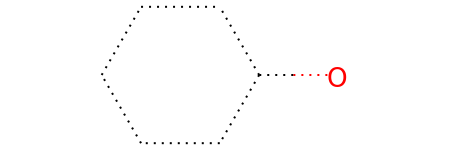

In [11]:
patt

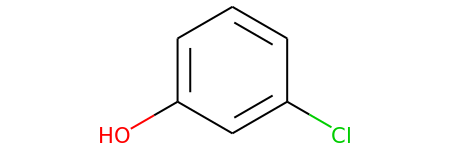

In [12]:
mol

In [14]:
def get_acidic_atom_class(Smiles):
    
    atom_class_dic = {}
    
    #patt_1 = Chem.MolFromSmarts('c[OH]') # 酚羟基
    patt_1 = Chem.MolFromSmarts('[OH]c1ccccc1') # 酚羟基
    patt_2 = Chem.MolFromSmarts('C[OH]') # 醇羟基
    patt_3 = Chem.MolFromSmarts('C([NH])=O') # 酰胺1
    patt_4 = Chem.MolFromSmarts('C([NH2])=O') # 酰胺2
    patt_5 = Chem.MolFromSmarts('O=S([NH])=O')  # 磺胺1
    patt_6 = Chem.MolFromSmarts('O=S([NH2])=O')  # 磺胺2
    patt_7 = Chem.MolFromSmarts('OC=O')  # 羧基
    
    mol = Chem.MolFromSmiles(Smiles)
    
    if mol.HasSubstructMatch(patt_1):
        atom_ids = mol.GetSubstructMatches(patt_1)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Phenol'
    
    if mol.HasSubstructMatch(patt_2):
        atom_ids = mol.GetSubstructMatches(patt_2)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Alcohol'
            
    if mol.HasSubstructMatch(patt_3):
        atom_ids = mol.GetSubstructMatches(patt_3)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide'
            
    if mol.HasSubstructMatch(patt_4):
        atom_ids = mol.GetSubstructMatches(patt_4)
        for i in atom_ids:
            atom_class_dic[i[1]] = 'Amide2'     
            
    if mol.HasSubstructMatch(patt_5):
        atom_ids = mol.GetSubstructMatches(patt_5)
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa'  
            
    if mol.HasSubstructMatch(patt_6):
        atom_ids = mol.GetSubstructMatches(patt_6)  
        for i in atom_ids:
            atom_class_dic[i[2]] = 'Sulfa2'  
        
    if mol.HasSubstructMatch(patt_7):
        atom_ids = mol.GetSubstructMatches(patt_7)  #羧基放后面就是了
        for i in atom_ids:
            atom_class_dic[i[0]] = 'Carboxylic Acid'  
        
        
    return atom_class_dic

In [15]:
atom_feature_class_lis = []
for smiles,atom_feature in zip(smiles_lis,atom_feature_lis):
    atom_class_dic = get_acidic_atom_class(smiles)
    for i in atom_class_dic.keys():
        #print(smiles)
        #print(atom_feature.size())
        #print(atom_feature[i],atom_class_dic[i])
        atom_feature_class_lis.append((atom_feature[i],atom_class_dic[i]))

In [16]:
import pickle
pickle.dump(atom_feature_class_lis,open('./Atom_Hidden_Features_Analysis/atom_feature_class_lis.pkl','wb'))  #后缀.pkl可加可不加

In [17]:
import pickle
atom_feature_class_lis = pickle.load(open('./Atom_Hidden_Features_Analysis/atom_feature_class_lis.pkl','rb'))

In [18]:
import numpy as np

In [28]:
Alcohol = []
Phenol = []
Carboxylic_Acid = []
Amide = []
Sulfa = []

for i,j in atom_feature_class_lis:
    if j == 'Alcohol':
        Alcohol.append(i.tolist())
    elif j == 'Phenol':
        Phenol.append(i.tolist())
    elif j == 'Carboxylic Acid':
        Carboxylic_Acid.append(i.tolist())
    elif j == 'Amide':
        Amide.append(i.tolist())    
    elif j == 'Sulfa':
        Sulfa.append(i.tolist())   

        
        
#     if j in ['Alcohol','Phenol','Carboxylic Acid','Amide','Sulfa']:
#         features.append(i.tolist())
#         ss_class.append(j)
# features = np.array(features)

In [30]:
X = Alcohol + Phenol + Carboxylic_Acid + Amide + Sulfa

In [32]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(X)  #导入数据，维度为4
pca = PCA(n_components=3)   #降到2维
pca.fit(X)                  #训练
newX=pca.fit_transform(X)   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX)   

[0.90134491 0.03307722 0.01430984]
[[ 0.55387997 -0.28498301 -0.25423942]
 [ 0.45220443 -0.39071987 -0.29474894]
 [ 0.0960735  -0.37440881 -0.10411237]
 ...
 [ 0.72113325 -0.28001571 -0.25211999]
 [-1.81006693 -0.19588981  0.03044903]
 [ 0.27632958 -0.17512378 -0.20177969]]


In [33]:
print(len(Alcohol))
print(len(Alcohol)+len(Phenol))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide))
print(len(Alcohol)+len(Phenol)+len(Carboxylic_Acid)+len(Amide)+len(Sulfa))

2181
3888
8754
10470
10958


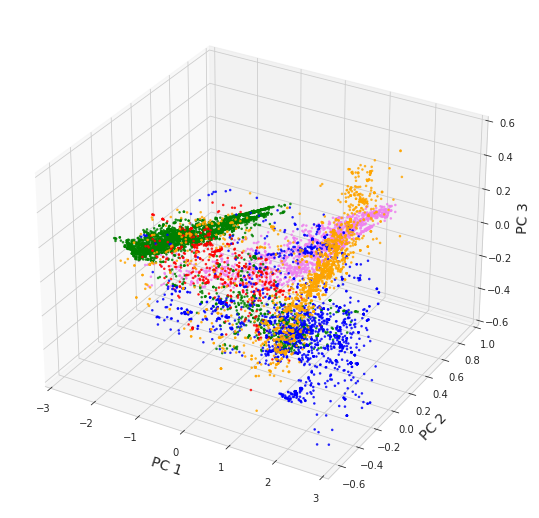

In [127]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(7,7))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2


ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange')
ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet')
ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green')
ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue')
ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red')

# ax.scatter(newX[:2181,0],newX[:2181,1],newX[:2181,2], s= 2.5,alpha = 0.75,c= 'orange',label='R-OH')
# ax.scatter(newX[2181:3888,0],newX[2181:3888,1],newX[2181:3888,2],s=2.5,alpha = 0.75,c='violet',label= 'Ar-OH')
# ax.scatter(newX[3888:8754,0],newX[3888:8754,1],newX[3888:8754,2],s= 2.5,alpha = 0.75,c='green',label= '- COOH')
# ax.scatter(newX[8754:10470,0],newX[8754:10470,1],newX[8754:10470,2],s= 2.5,alpha = 0.75,c='blue',label= '- CONH${_2}$')
# ax.scatter(newX[10470:10958,0],newX[10470:10958,1],newX[10470:10958,2],s= 2.5,alpha = 0.75,c='red',label= '- SO${_2}$NH${_2}$')

ax.set_xlabel('    PC 1    ',fontsize=14)
ax.set_ylabel('    PC 2    ',fontsize=14)
ax.set_zlabel('    PC 3    ',fontsize=14)
ax.set_xlim(-3,3)
ax.set_ylim(-0.7,1)
ax.set_zlim3d(-0.6,0.6)
#plt.zlim(-0.6,0.6)
#ax.legend(loc='best',fontsize=14)

plt.show()

In [ ]:

ax.scatter(x1, y1, z1, c='r', label='A')
ax.scatter(x2, y2, z2, c='g', label='B')
ax.scatter(x3, y3, z3, c='y', label='C')

In [19]:
features,ss_class = [],[]
for i,j in atom_feature_class_lis:
    if j in ['Alcohol','Phenol','Carboxylic Acid','Amide','Sulfa']:
        features.append(i.tolist())
        ss_class.append(j)
features = np.array(features)

In [20]:
features.shape

(10958, 200)

In [21]:
X = features

In [22]:
import numpy as np
from sklearn.decomposition import PCA
#X = np.array(fps)  #导入数据，维度为4
pca = PCA(n_components=3)   #降到2维
pca.fit(X)                  #训练
newX=pca.fit_transform(X)   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX)    

[0.90134491 0.03307722 0.01430984]
[[-0.05144258  0.09021653 -0.09700037]
 [-0.0078706   0.09503789 -0.07004021]
 [-0.65933787 -0.05260945 -0.11358983]
 ...
 [-1.99467115 -0.17330281  0.11824395]
 [-1.9946711  -0.17330282  0.11824395]
 [-1.93737973 -0.2135392   0.02728265]]


In [23]:
#c = ['red'] * len(features)

In [24]:
#set(ss_class)
c = []
for i in ss_class:
    if i == 'Alcohol':
        c.append('red')
    elif i == 'Amide':
        c.append('blue')
    elif i == 'Carboxylic Acid':
        c.append('green')
    elif i == 'Phenol':
        c.append('orange')
    elif i == 'Sulfa':
        c.append('violet')

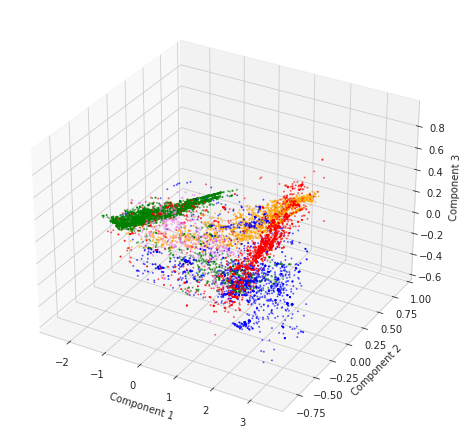

In [25]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2



ax.scatter(newX[:,0],newX[:,1],newX[:,2],c = c[:],s= 1,alpha = 1/2)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

In [19]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [1]:
patt_1 = Chem.MolFromSmarts('c[OH]')

NameError: name 'Chem' is not defined

In [ ]:
胺好像分析不了

In [22]:
def draw_pca_result(file_name,Chain_id,neigh_num,dim):
    
    if dim == 3:
        feature = Get_3D_feature(file_name,neigh_num,Chain_id)()
    elif dim == 1:
        feature = Get_1D_feature(file_name,neigh_num,Chain_id)()
        
    features = []
    features.append(feature)
    features = np.array(features)


    X = features.squeeze(0).reshape(-1,dim * neigh_num)
    pca = PCA(n_components=2)
    newX = pca.fit_transform(X)
    #sns.scatterplot(newX[neigh_num:neigh_num*-1,0],newX[neigh_num:neigh_num*-1,1], hue= ss_class[neigh_num:neigh_num*-1])

(tensor([0.0921, 0.2477, 0.4085, 0.1312, 0.0000, 0.1738, 0.1512, 0.2639, 0.0000,
         0.4587, 0.1060, 0.1090, 0.1411, 0.1313, 0.0547, 0.2174, 0.0747, 0.0757,
         0.0000, 0.0000, 0.1502, 0.1586, 0.0000, 0.1644, 0.0000, 0.1657, 0.1302,
         0.0000, 0.1637, 0.3875, 0.1559, 0.1725, 0.0000, 0.0000, 0.1211, 0.0000,
         0.0000, 0.3862, 0.1436, 0.1571, 0.1232, 0.1105, 0.0698, 0.1529, 0.1394,
         0.3181, 0.3132, 0.0000, 0.0000, 0.2092, 0.0969, 0.0000, 0.0000, 0.1451,
         0.0000, 0.0000, 0.1009, 0.1466, 0.2433, 0.0000, 0.1606, 0.3645, 0.1497,
         0.1467, 0.0746, 0.0000, 0.1575, 0.0000, 0.1169, 0.0738, 0.0000, 0.1545,
         0.1937, 0.2122, 0.3956, 0.0000, 0.0723, 0.0000, 0.0000, 0.0000, 0.5254,
         0.0000, 0.0000, 0.0000, 0.0513, 0.0884, 0.0000, 0.0000, 0.0000, 0.0376,
         0.2326, 0.0752, 0.1548, 0.0271, 0.3580, 0.0897, 0.0000, 0.0000, 0.0876,
         0.0000, 0.4739, 0.1384, 0.0000, 0.0499, 0.1049, 0.0182, 0.1521, 0.1388,
         0.0000, 0.3072, 0.1

In [ ]:
#data= pickle.load(open('file_path','rb'))

In [117]:
get_acidic_atom_class('COc1nc(C)cc(O)n1')

{8: 'Phenol'}

In [120]:
bg = smiles_to_bigraph(smiles= 'COc1nc(C)cc(O)n1', 
          node_featurizer=node_featurizer,
          edge_featurizer=edge_featurizer,
          canonical_atom_order= False)

with torch.no_grad():
    model.eval()
    g_feats,atom_pka,node_feats = model(bg,bg.ndata['h'], bg.edata['h'])

In [122]:
node_feats.size()

torch.Size([10, 200])

In [1]:
from rdkit import Chem

In [2]:
m = Chem.MolFromSmiles('c1ccccc1OC')
patt = Chem.MolFromSmarts('OC')
flag =m.HasSubstructMatch(patt)

molecu m contains group -OCH3


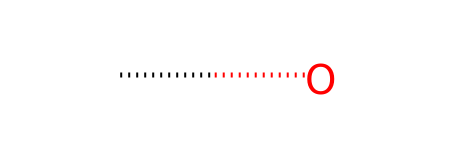

In [3]:
patt

In [21]:
# 酚羟基

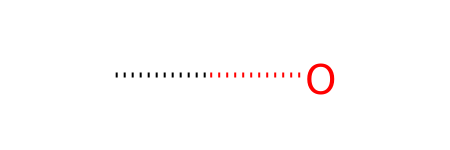

In [55]:
m = Chem.MolFromSmiles('OC1=CC=CC=C1')
patt = Chem.MolFromSmarts('c[OH]')
patt

In [58]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatches(patt)
    for i in atomids:
        print(i)
    print(atomids)

True
(1, 0)
((1, 0),)


In [45]:
# 醇羟基

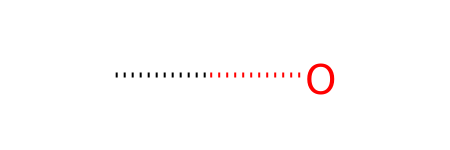

In [48]:
m = Chem.MolFromSmiles('OCC1=C(CO)C=CC=C1')
patt = Chem.MolFromSmarts('C[OH]')
patt

In [49]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(1, 0)


In [ ]:
#酰胺基-一个H

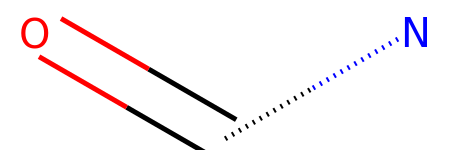

In [36]:
m = Chem.MolFromSmiles('NC(C1=CC=CC(C(NC)=O)=C1)=O')
patt = Chem.MolFromSmarts('C([NH])=O')
patt

In [37]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(7, 8, 10)


In [ ]:
#酰胺基-2个H

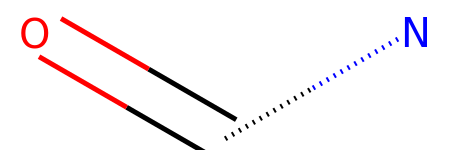

In [38]:
m = Chem.MolFromSmiles('NC(C1=CC=CC(C(NC)=O)=C1)=O')
patt = Chem.MolFromSmarts('C([NH2])=O')
patt

In [39]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(1, 0, 12)


In [40]:
#磺胺基-1个H

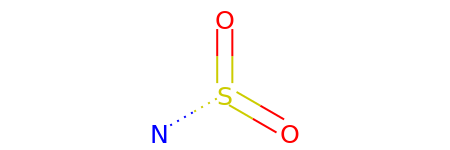

In [41]:
m = Chem.MolFromSmiles('O=S(CC1=CC2=C(S(=O)(NC)=O)C=CC=C2C=C1)(N)=O')
patt = Chem.MolFromSmarts('O=S([NH])=O')
patt

In [42]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(8, 7, 9, 11)


In [ ]:
#磺胺基-2个H

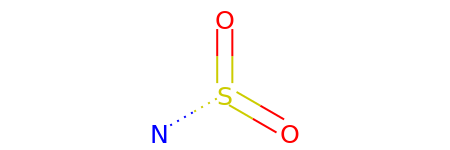

In [43]:
m = Chem.MolFromSmiles('O=S(CC1=CC2=C(S(=O)(NC)=O)C=CC=C2C=C1)(N)=O')
patt = Chem.MolFromSmarts('O=S([NH2])=O')
patt

In [44]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(0, 1, 18, 19)


In [ ]:
#羧基

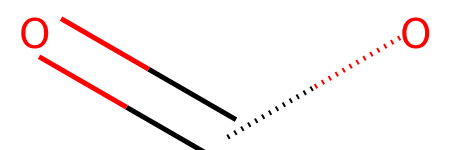

In [76]:
m = Chem.MolFromSmiles('OC1=CC(CC(O)=O)=C(O)C(CO)=C1')
patt = Chem.MolFromSmarts('OC=O')
patt

In [77]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(6, 5, 7)


In [91]:
get_acidic_atom_class('OC1=CC(CC(O)=O)=C(O)C(CO)=C1CCC(CNC(CC(N)=O)=O)CC(CCCS(=O)(NC)=O)S(=O)(N)=O')

{0: 'Phenol',
 9: 'Phenol',
 6: 'Carboxylic Acid',
 12: 'Alcohol',
 18: 'Amide',
 22: 'Amide',
 32: 'Sulfa',
 37: 'Sulfa'}

In [92]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [93]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [94]:
mol = Chem.MolFromSmiles("OC1=CC(CC(O)=O)=C(O)C(CO)=C1CCC(CNC(CC(N)=O)=O)CC(CCCS(=O)(NC)=O)S(=O)(N)=O")

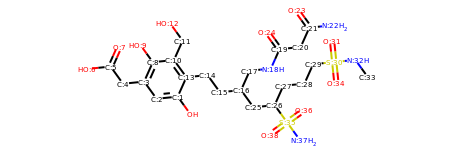

In [95]:
mol_with_atom_index(mol)

In [ ]:
磺胺基一个H

In [ ]:
O=S([NH])=O

In [ ]:
磺胺基2个H

In [ ]:
#酰胺基-2个H

In [35]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

False


In [24]:
# 羧基

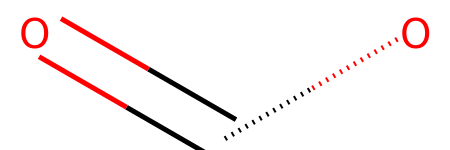

In [25]:
m = Chem.MolFromSmiles('OC1=CC(C(O)=O)=CC=C1')
patt = Chem.MolFromSmarts('C([OH])=O')
patt

In [20]:
flag = m.HasSubstructMatch(patt)

print(flag)

if flag:
    atomids = m.GetSubstructMatch(patt)
    print(atomids)

True
(4, 5, 6)


In [ ]:
m = Chem.MolFromSmiles('OC1=CC(C(O)=O)=CC=C1')
patt = Chem.MolFromSmarts('C([OH])=O')
patt